# Creating DC2 Templates

Loading Brown et al. templates with emission lines masked we will attempt to extrapolate in color space and create new templates that better span the color space of DC2 galaxies. To do the extrapolation we will use [ESP](https://github.com/jbkalmbach/ESP).

## Creating templates with LSST colors

CosmoDC2 comes with rest frame magnitudes in the LSST bands. We can use these to map out the color space and create new templates to better cover this color space.

### Load templates and perform PCA

In [3]:
import esp
import os
import numpy as np
import GCRCatalogs
from copy import deepcopy
from matplotlib import pyplot as plt
from lsst.sims.photUtils import BandpassDict, Bandpass, Sed
from sklearn.cluster import KMeans
%matplotlib inline

Here we load the Brown templates from the data directory. To get better coverage in the bluer edge of color space we also include "two single stellar population models with low/no dust and low metallicity that were used with BPZ for the HUDF to mimic super blue galaxies at z~5-7." (From Sam's comment [here](https://github.com/LSSTDESC/pz_pdf/issues/2)).

In [2]:
brown_data_dir = '../../data/brown_templates/'
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(brown_data_dir)

File On 100 out of 131
Done loading spectra from file


In [3]:
new_spec_list = []
for sed_obj in pca_obj.spec_list_orig:
    new_sed_obj = deepcopy(sed_obj)
    new_sed_obj.wavelen = new_sed_obj.wavelen/10. #Convert to nanometers
    new_spec_list.append(new_sed_obj)
pca_obj.spec_list_orig = new_spec_list

Now we perform PCA on the templates truncating them at 1200.0 nanometers and keeping 10 components

In [4]:
pca_obj.PCA(minWavelen=1., maxWavelen=1200., comps=10)

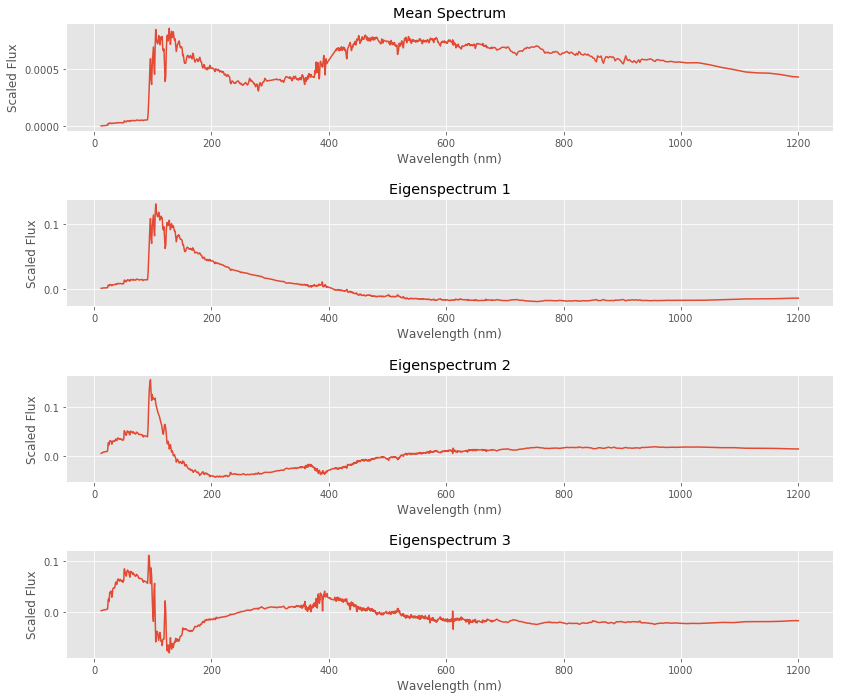

In [5]:
plotter = esp.plotUtils()
fig = plt.figure(figsize=(12, 10))
fig = plotter.plot_eigenspectra(pca_obj, 3, fig = fig)

In [8]:
### If there is already a folder for storing the PCA information uncomment below
#! rm -rf brown_pca

In [9]:
os.mkdir('brown_pca')
pca_obj.write_output('brown_pca')

In [118]:
print('The 10 eigenspectra explain %.4f percent of the variance in the input template set.' % (100*np.sum(pca_obj.exp_var)))

The 10 eigenspectra explain 99.2942 percent of the variance in the input template set.


### Load the DC2 data from `gcr_catalogs`

In [169]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.0_9556')

In [120]:
### To see a list of all the possible quantities uncomment below
#print(sorted(catalog.list_all_quantities()))

In [170]:
new_pca_obj = esp.pcaSED()
new_pca_obj.load_pca_output('brown_pca')

Here we will load in the LSST z=0 magnitudes of the cosmoDC2 galaxies.

In [171]:
data = catalog.get_quantities(['Mag_true_u_lsst_z0', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0',
                               'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 'Mag_true_Y_lsst_z0'])

In [172]:
data

{'Mag_true_r_lsst_z0': array([-21.39925957, -16.24744034, -16.37441063, ..., -15.97449875,
        -17.01153564, -16.50214195], dtype=float32),
 'Mag_true_i_lsst_z0': array([-21.73043251, -16.35010529, -16.68346024, ..., -16.11528587,
        -17.02253723, -16.54382324], dtype=float32),
 'Mag_true_Y_lsst_z0': array([-22.11238098, -16.4149437 , -16.95729065, ..., -16.26852989,
        -17.03161049, -16.57671165], dtype=float32),
 'Mag_true_g_lsst_z0': array([-20.80197525, -16.03988266, -15.86121559, ..., -15.84185791,
        -16.98348618, -16.42822838], dtype=float32),
 'Mag_true_u_lsst_z0': array([-19.53089905, -15.20400429, -14.86820984, ..., -15.15490532,
        -16.39190292, -15.76977348], dtype=float32),
 'Mag_true_z_lsst_z0': array([-21.96195984, -16.38772202, -16.85533333, ..., -16.19926643,
        -17.01563072, -16.55456543], dtype=float32)}

In [173]:
len(data['Mag_true_Y_lsst_z0'])

17104963

In order to keep the dataset a reasonable size in the Gaussian Process below we will thin it out by a factor of 1000. This should still provide a representative color range of the full dataset. We do this and calculate the colors from the magnitudes in the step below.

In [174]:
colors = []
for i in range(0,len(data['Mag_true_Y_lsst_z0']), 1000):
    single_gal = []
    for band in ['u', 'g', 'r', 'i', 'z', 'Y']:
        single_gal.append(data['Mag_true_%s_lsst_z0' % band][i])
    single_gal = np.array(single_gal)
    colors.append(single_gal[:-1] - single_gal[1:])
lsst_dc2_colors = np.array(colors)

In [175]:
# Load the LSST bandpasses
lsst_bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles()

Here we calculate the template colors in the LSST bandpasses and compare to the cosmoDC2 galaxies.

In [176]:
lsst_template_colors = new_pca_obj.calc_colors(lsst_bandpass_dict, 10)

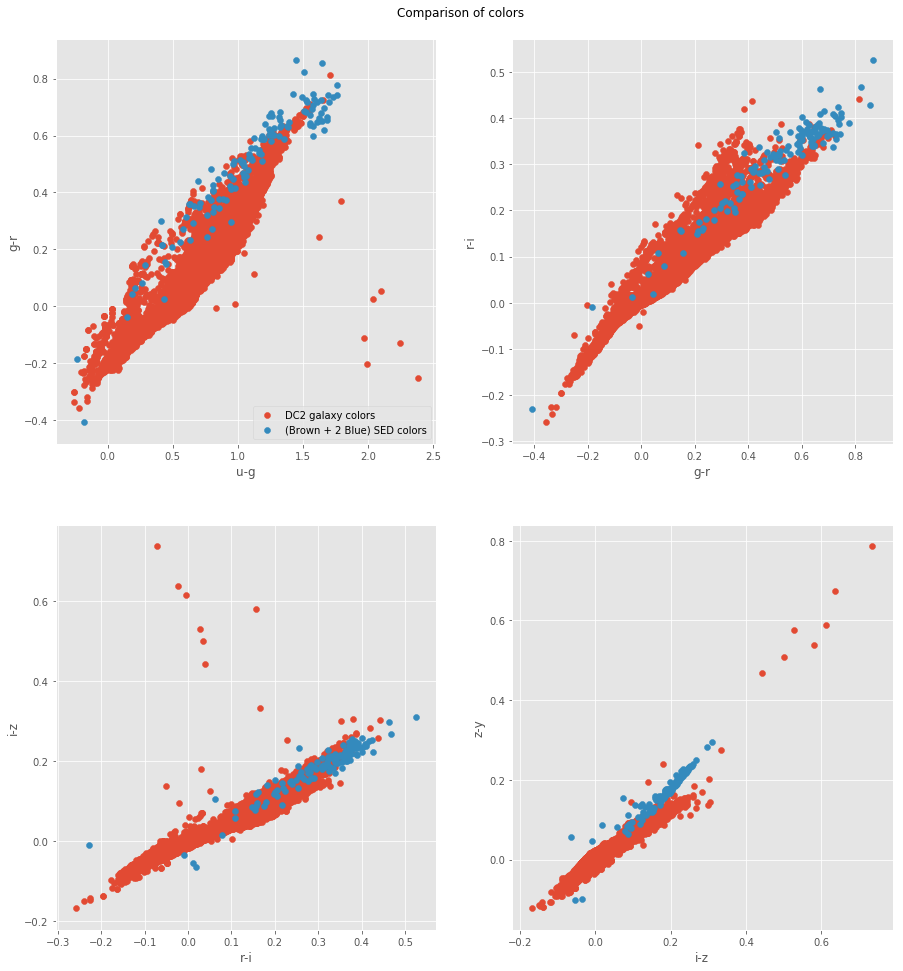

In [177]:
fig = plt.figure(figsize=(15,15))
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
for i in range(4):
    col_0 = i
    col_1 = i+1
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,col_0], lsst_dc2_colors[:,col_1], label='DC2 galaxy colors')
    plt.scatter(lsst_template_colors[:,col_0], lsst_template_colors[:,col_1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 0:
        plt.legend(loc=4)
plt.suptitle('Comparison of colors')
plt.subplots_adjust(top=0.95)

### Run the Gaussian Process method from ESP in the color space to generate new templates.

What we are doing below is fitting a Gaussian process for the PCA coefficients of the templates to their locations in the LSST color space. Then for every cosmoDC2 color we are predicting PCA cofficients for those locations in color space. Using these PCA coefficients we then reconstruct a spectrum for that color location and recalculate the color of the new "template". Below we compare how well the extrapolated template reproduces the input colors at that location.

In [178]:
gp_obj = esp.gaussianProcessEstimate(new_pca_obj, lsst_bandpass_dict, lsst_dc2_colors)

In [179]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=len(lsst_dc2_colors[0]))

In [180]:
gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=lsst_bandpass_dict)

In [181]:
lsst_gp_colors = gp_spec.calc_colors(lsst_bandpass_dict, 10)

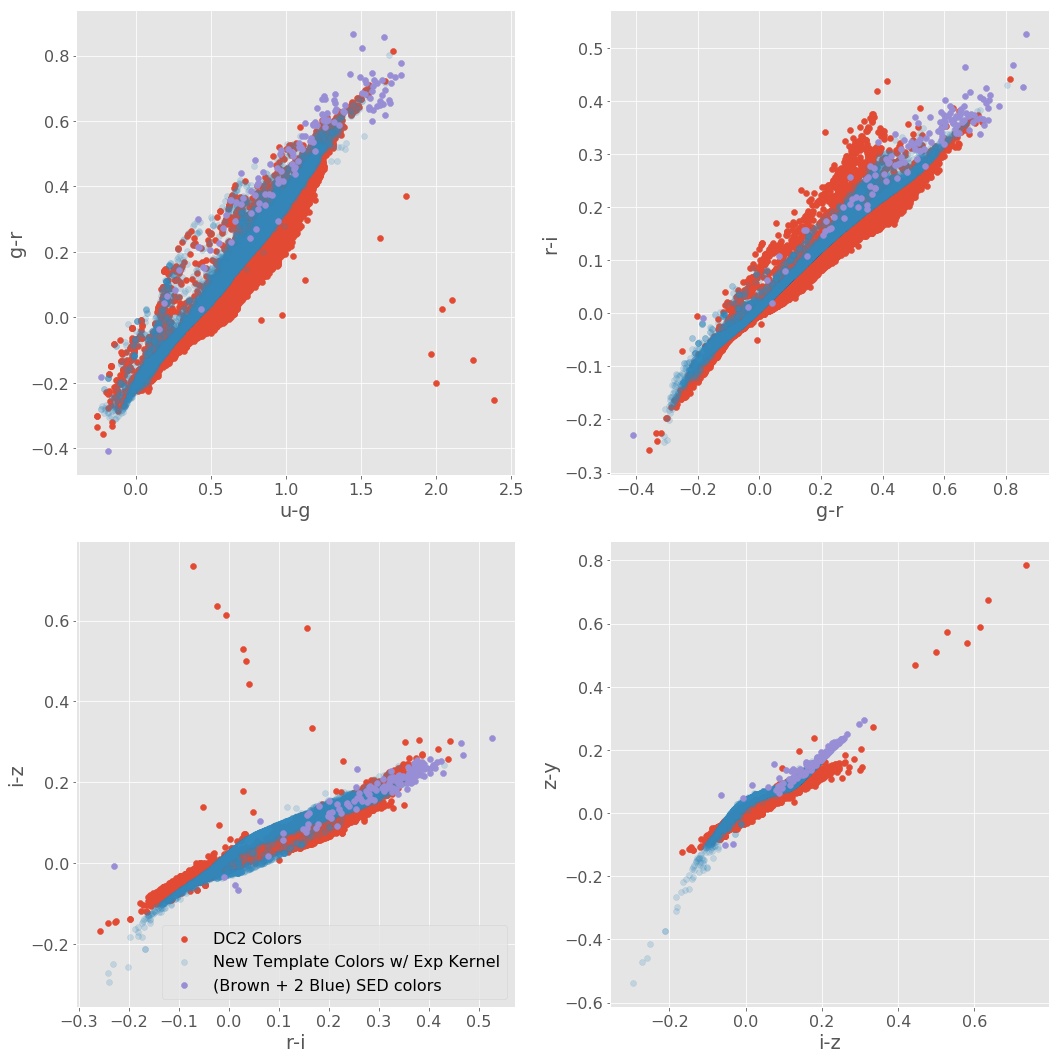

In [102]:
fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[:,i], lsst_gp_colors[:,i+1], alpha=0.2, label='New Template Colors w/ Exp Kernel')
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

Compare how closely we are able to reconstruct the colors for each cosmoDC2 galaxy with a new template.

In [55]:
#m32_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [49]:
#m52_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [41]:
#sq_exp_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [183]:
exp_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

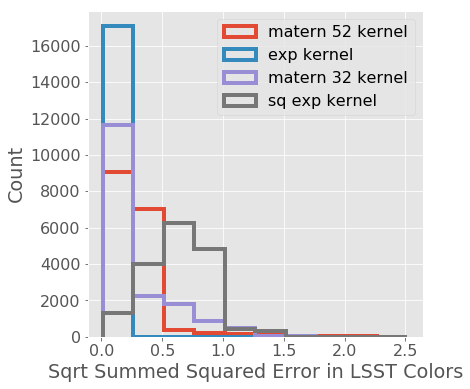

In [67]:
fig = plt.figure(figsize=(6,6))
n, bins, _ = plt.hist(m52_gp_lsst, histtype='step', label='matern 52 kernel', lw=4)
plt.hist(exp_gp_lsst, bins=bins, histtype='step', label='exp kernel', lw=4)
plt.hist(m32_gp_lsst, bins=bins, histtype='step', label='matern 32 kernel', lw=4, range=(0, 2.5))
plt.hist(sq_exp_gp_lsst, bins=bins, histtype='step', label='sq exp kernel', lw=4)
plt.legend()
plt.xlabel('Sqrt Summed Squared Error in LSST Colors')
plt.ylabel('Count')

In [68]:
np.exp(gp_spec.params)

array([[  2.69450348e-04,   7.67487438e+02],
       [  4.66690967e-05,   4.34507331e+02],
       [  3.37825402e-06,   3.10196657e+00],
       [  5.86514249e-06,   9.80203928e+01],
       [  6.49955235e-07,   4.34754734e+00],
       [  5.10518382e-08,   9.33470549e-04],
       [  1.18320071e-06,   2.50193448e+01],
       [  1.03354531e-06,   3.63523676e+01],
       [  2.94373324e-08,   1.10292057e-02],
       [  3.91339572e-08,   3.54681213e-02]])

It seems that we should use the Exponential kernel to create our templates.

### Pick the new templates that most accurately recreate the input colors to use as a new set of templates.

First we will find the 5000 new templates that best recreate the input colors from cosmoDC2 galaxies.

In [184]:
min_err_idx = np.argsort(exp_gp_lsst)
min_err_idx = min_err_idx[:5000]

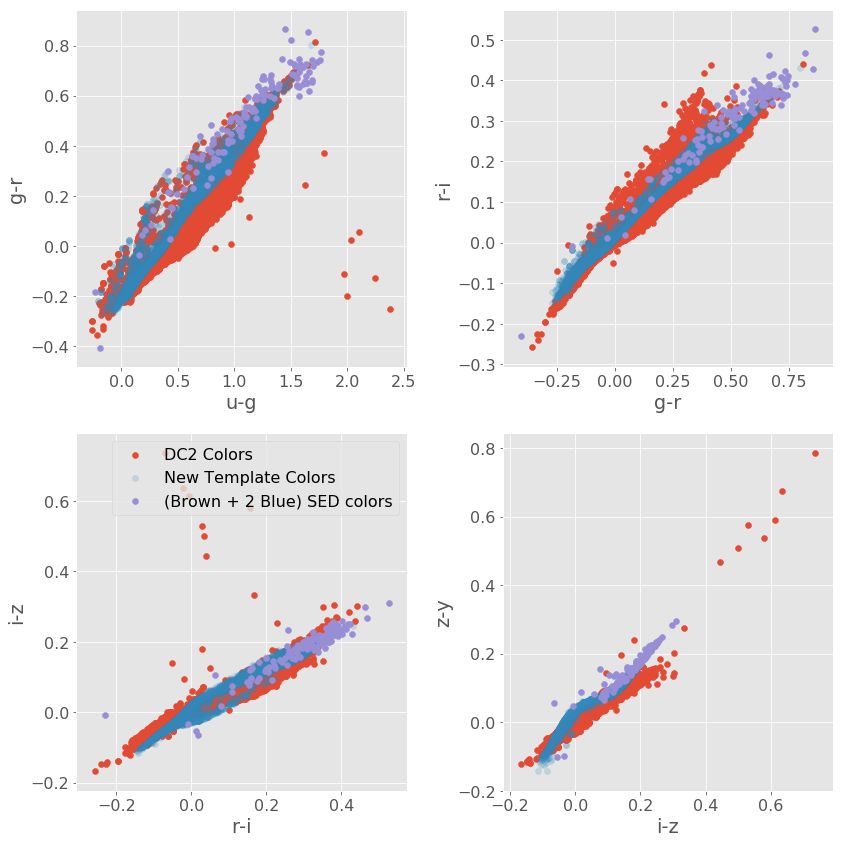

In [103]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[min_err_idx,i], lsst_gp_colors[min_err_idx,i+1], alpha=0.2, label='New Template Colors')
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

Next we will cluster these high-grade templates into 50 clusters in color space to get a good spread of new locations for new templates and then randomly choose one template from each cluster to be the point at which we will create a new template.

In [185]:
rand_state = np.random.RandomState(3213)
kmeans = KMeans(n_clusters = 50, random_state=rand_state).fit(lsst_gp_colors[min_err_idx])

In [186]:
new_template_idx = []
for cluster_num in range(50):
    cluster_idx = np.where(kmeans.labels_ == cluster_num)[0]
    new_template_idx.append(rand_state.choice(min_err_idx[cluster_idx]))

Now we randomly choose one template from each cluster and use the PCA coefficients for these points in color space to generate a new set of 50 templates to complement the (Brown + 2 Blue) templates.

In [188]:
new_templates = gp_spec.reconstruct_spectra(10)[new_template_idx]

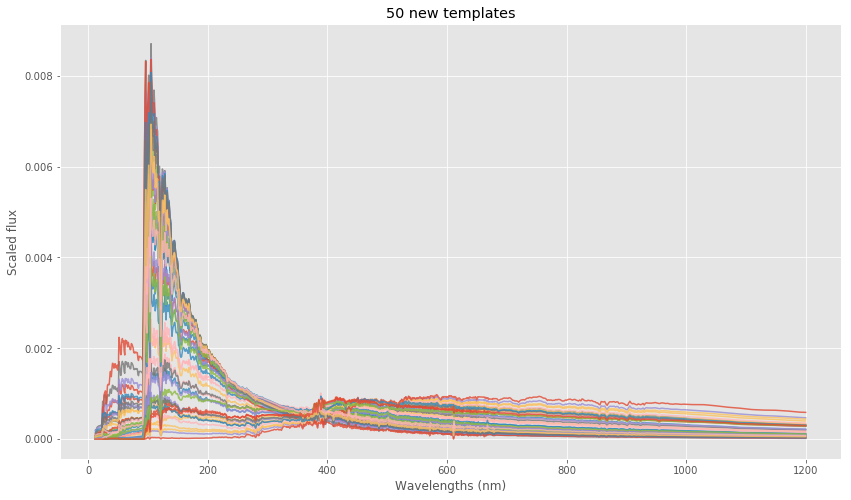

In [189]:
fig = plt.figure(figsize=(14, 8))
for i in range(50):
    plt.plot(new_pca_obj.wavelengths, new_templates[i], alpha=0.8)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Scaled flux')
plt.title('50 new templates')

We take these new templates and see where they are in color space compared to DC2 and the (Brown + 2 Blue) templates

In [190]:
lsst_new_template_colors = []
for sed_template in new_templates:
    test_sed = Sed()
    test_sed.setSED(wavelen=new_pca_obj.wavelengths, flambda=sed_template)
    maglist = lsst_bandpass_dict.magListForSed(test_sed)
    colors_list = maglist[:-1] - maglist[1:]
    lsst_new_template_colors.append(colors_list)

In [191]:
lsst_new_template_colors = np.array(lsst_new_template_colors)

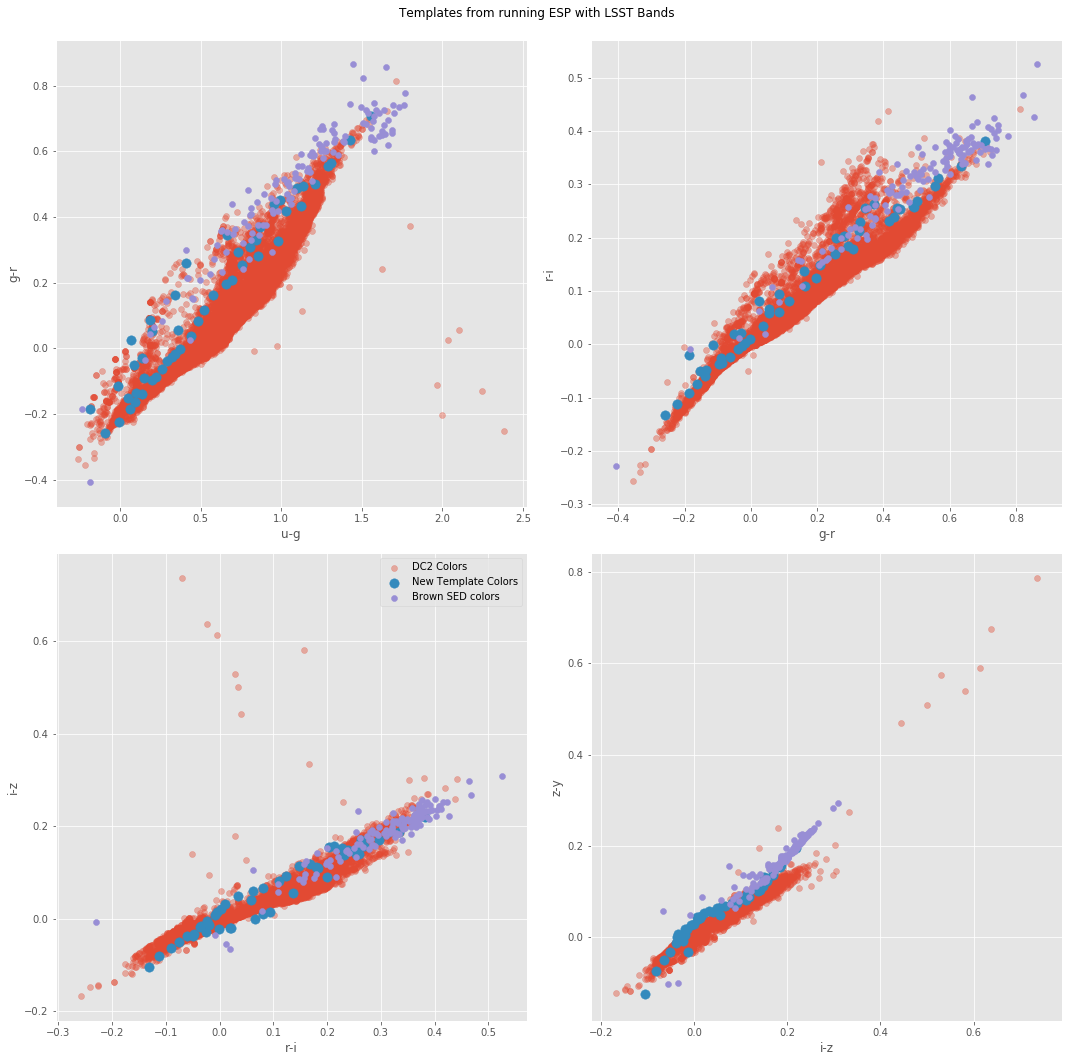

In [217]:
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors', alpha=0.4)
    plt.scatter(lsst_new_template_colors[:,i], lsst_new_template_colors[:,i+1], label='New Template Colors', s=88)
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='Brown SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Templates from running ESP with LSST Bands')

Finally, we write the templates to file.

In [107]:
### To write the new templates to file:
# (Changed to be written in angstroms to be consistent with Brown templates given)
template_folder = 'new_templates'
os.mkdir(template_folder)
sed_names = []
spec_on = 0
for sed_obj in new_templates:
    with open(os.path.join(template_folder, '%i.sed' % spec_on), 'w') as f:
        f.write('# Wavelength(angstrom)  Flambda(ergs/cm^s/s/angstrom)\n')
        for line_idx in range(len(new_pca_obj.wavelengths)):
            print(10.*new_pca_obj.wavelengths[line_idx], 0.1*sed_obj[line_idx], file=f)
    spec_on += 1

## Creating templates with CosmoDC2 tophat filters.

CosmoDC2 catalogs also have a set of tophat filters in a large set of wavelength bins from 100 nm up to around 2 microns. We can use these instead of LSST bands and compare the results.

### Getting the information out of CosmoDC2 with `GCR-Catalogs`

We need to get information on the shape of the tophat bands as well as the flux in each of the bands for the cosmoDC2 galaxies.

In [6]:
sed_label = []
sed_min_wave = []
sed_wave_width = []
for quant_label in sorted(catalog.list_all_quantities()):
    if (quant_label.startswith('sed') and (quant_label.endswith('bulge') or quant_label.endswith('disk'))):
        sed_label.append(quant_label)
        label_split = quant_label.split('_')
        sed_min_wave.append(int(label_split[1])/10)
        sed_wave_width.append(int(label_split[2])/10)
bin_order = np.argsort(sed_min_wave)
sed_label = np.array(sed_label)[bin_order]
sed_min_wave = np.array(sed_min_wave)[bin_order]
sed_wave_width = np.array(sed_wave_width)[bin_order]

In [8]:
sed_min_wave = np.unique(sed_min_wave)
sed_wave_width = np.unique(sed_wave_width)

Now we have the names of the columns we need and we know the starting wavelength and width of each band.

In [9]:
sed_min_wave, sed_wave_width

(array([  100. ,   124.6,   155.2,   193.3,   240.7,   299.8,   318.4,
          338.1,   359. ,   381.2,   404.8,   429.9,   456.5,   484.8,
          514.8,   546.7,   580.6,   616.6,   654.8,   695.4,   738.5,
          784.3,   832.9,   884.6,   939.5,   997.8,  1146.7,  1317.7,
         1514.3,  1740.2]),
 array([  18.6,   19.7,   20.9,   22.2,   23.6,   24.6,   25.1,   26.6,
          28.3,   30. ,   30.6,   31.9,   33.9,   36. ,   38.1,   38.2,
          40.6,   43.1,   45.8,   47.4,   48.6,   51.7,   54.9,   58.3,
          59.1,  148.9,  171. ,  196.6,  225.9,  259.6]))

In [10]:
columns = []
for sed_bin in sed_label:
    columns.append(sed_bin)

In [11]:
data = catalog.get_quantities(columns)

In [12]:
len(data[columns[0]])

17104963

Here we set up the bandpass dictionary to calculate the template colors in the tophat bands.  We skip the last 4 bandpasses that go past the LSST range so we can use the same PCA coefficients as we did above.

In [13]:
wavelen = np.arange(99., 1200, 0.1)

In [14]:
len(sed_min_wave)

30

In [15]:
BandpassList = []
bp_names = []
# Skip the last 4 bandpasses that go past the LSST range so we can use the same PCA coefficients
for i in range(26):#range(len(sed_min_wave)):

    pass_through = np.where(((wavelen >= sed_min_wave[i]) & 
                             (wavelen <= (sed_min_wave[i] + sed_wave_width[i]))))

    sb = np.zeros(len(wavelen))
    sb[pass_through] = 1.0
    
    bp = esp.lsst_utils.Bandpass()
    bp.setBandpass(wavelen, sb, wavelen_min=100., wavelen_max=1200., wavelen_step=0.1)
    BandpassList.append(bp)
    bp_names.append('band_%i' % i)
bp_dict = esp.lsst_utils.BandpassDict(BandpassList, bp_names)

In [16]:
bulge_fluxes = []
disk_fluxes = []
for label in sed_label:
    if label.endswith('bulge'):
        bulge_fluxes.append(data[label])
    else:
        disk_fluxes.append(data[label])
bulge_fluxes = np.array(bulge_fluxes)
disk_fluxes = np.array(disk_fluxes)
total_fluxes = bulge_fluxes + disk_fluxes

In [17]:
np.shape(total_fluxes)

(30, 17104963)

We turn the fluxes in the tophat bands into magnitudes and then colors with units of magnitudes.

In [18]:
total_mags =  -2.5*np.log10(total_fluxes)

In [25]:
total_colors = total_mags[:-1] - total_mags[1:]

In [26]:
total_colors = total_colors.T

In [27]:
np.shape(total_colors)

(17104963, 29)

In [22]:
tophat_template_colors = new_pca_obj.calc_colors(bp_dict, 10)

Once again we thin by a factor of 1000.

In [28]:
tophat_dc2_colors = total_colors[::1000,:-4]

In [30]:
np.shape(tophat_dc2_colors)

(17105, 25)

Finally we have a set of colors for the templates and the cosmoDC2 galaxies from 26 tophat bands.

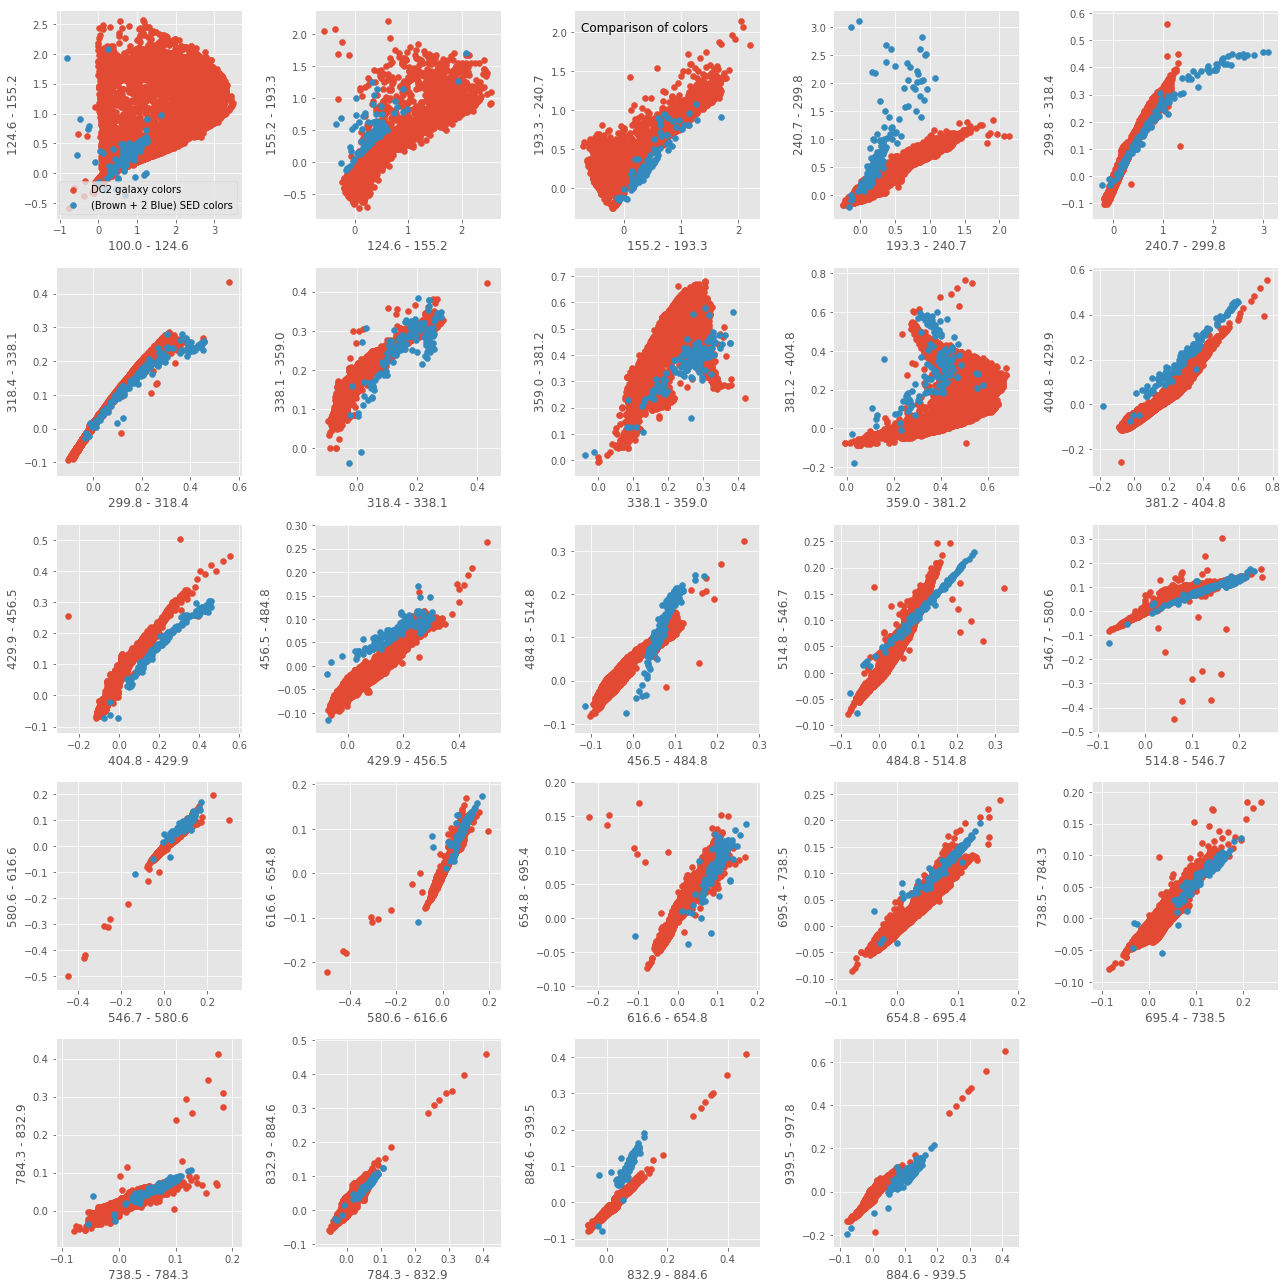

In [39]:
fig = plt.figure(figsize=(18,18))
color_labels = ['%s - %s' % (sed_min_wave[i], sed_min_wave[i+1]) for i in range(25)]
for i in range(24):
    col_0 = i
    col_1 = i+1
    fig.add_subplot(5,5,i+1)
    plt.scatter(tophat_dc2_colors[:,col_0], tophat_dc2_colors[:,col_1], label='DC2 galaxy colors')
    plt.scatter(tophat_template_colors[:,col_0], tophat_template_colors[:,col_1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 0:
        plt.legend(loc=4)
plt.suptitle('Comparison of colors')
plt.subplots_adjust(top=0.95)
plt.tight_layout()

### Fit the Gaussian Process

We fit the Gaussian Process as we did above using the new set of colors.

In [197]:
gp_obj = esp.gaussianProcessEstimate(new_pca_obj, bp_dict, tophat_dc2_colors)

In [198]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=len(tophat_dc2_colors[0]))

In [199]:
gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=bp_dict)

In [200]:
tophat_gp_colors = gp_spec.calc_colors(bp_dict, 10)

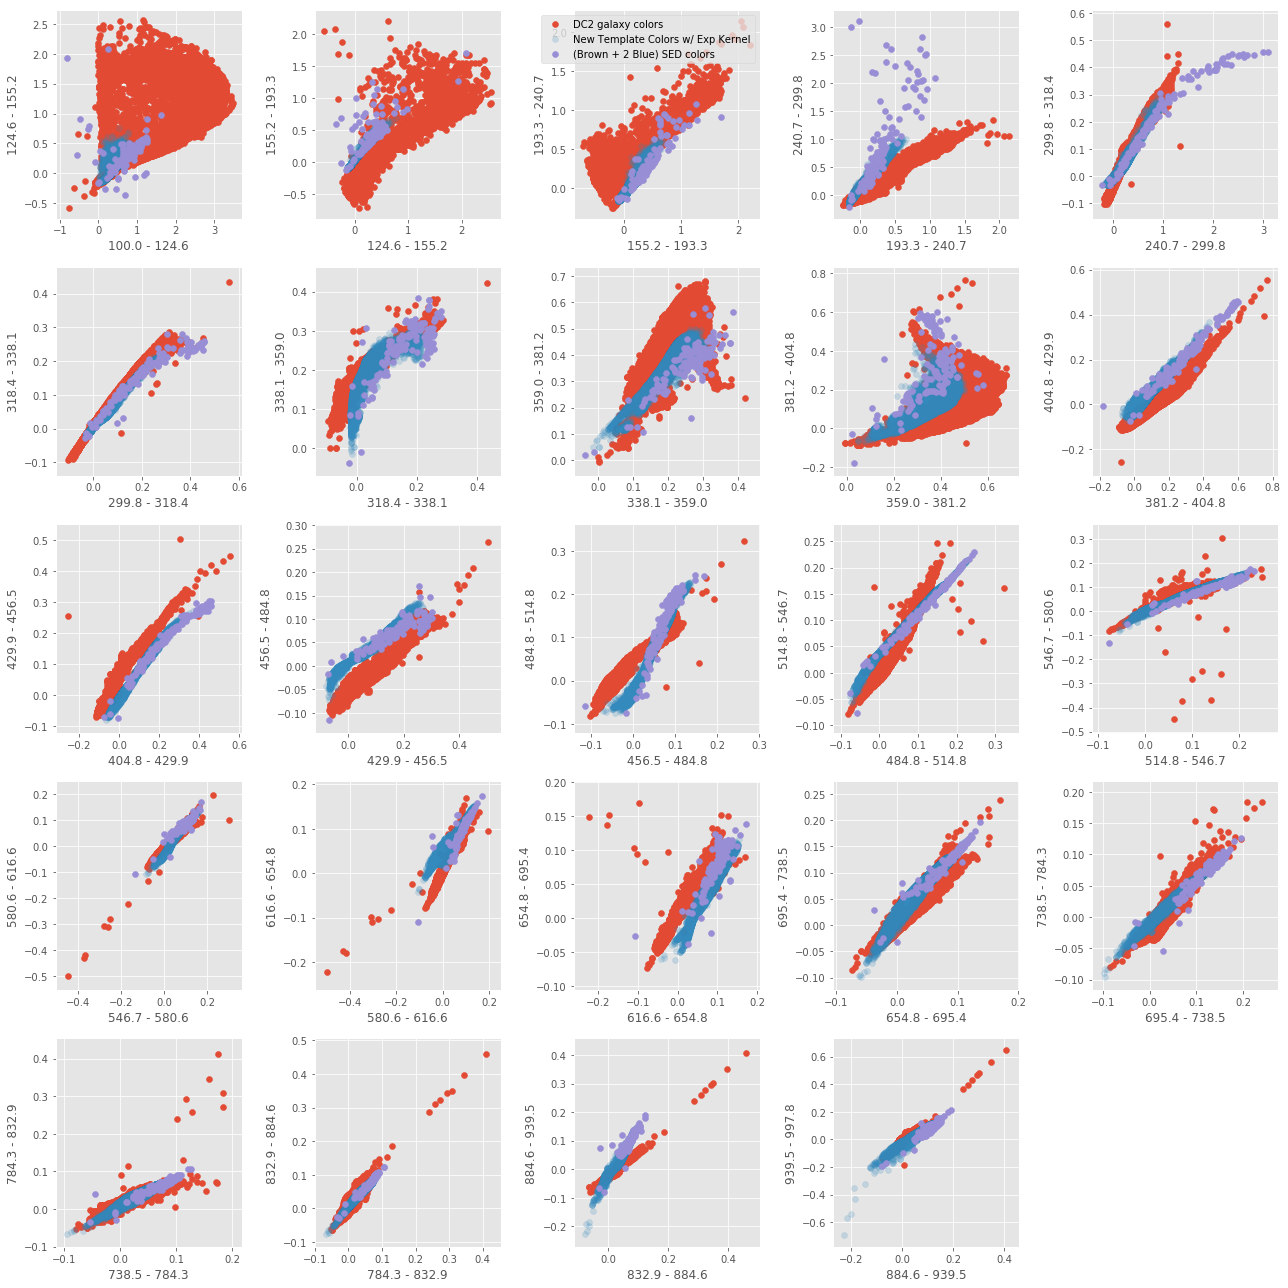

In [201]:
fig = plt.figure(figsize=(18,18))
color_labels = ['%s - %s' % (sed_min_wave[i], sed_min_wave[i+1]) for i in range(25)]
for i in range(24):
    col_0 = i
    col_1 = i+1
    fig.add_subplot(5,5,i+1)
    plt.scatter(tophat_dc2_colors[:,col_0], tophat_dc2_colors[:,col_1], label='DC2 galaxy colors')
    plt.scatter(tophat_gp_colors[:,i], tophat_gp_colors[:,i+1], alpha=0.2, label='New Template Colors w/ Exp Kernel')
    plt.scatter(tophat_template_colors[:,col_0], tophat_template_colors[:,col_1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

In [202]:
#exp_gp_tophat = np.sqrt(np.sum(np.square(tophat_gp_colors - tophat_dc2_colors), axis=1))

In [141]:
#sq_exp_gp_tophat = np.sqrt(np.sum(np.square(tophat_gp_colors - tophat_dc2_colors), axis=1))

In [156]:
#m32_gp_tophat = np.sqrt(np.sum(np.square(tophat_gp_colors - tophat_dc2_colors), axis=1))

In [112]:
#m52_gp_tophat = np.sqrt(np.sum(np.square(tophat_gp_colors - tophat_dc2_colors), axis=1))

Since we are going to select the best 5000 it seems we should use the exponential kernel again even though it does seem to have a longer tail.

/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/lib/function_base.py:748: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/global/common/software/lsst/common/miniconda/py3-4.3.21-env/lib/python3.6/site-packages/numpy/lib/function_base.py:749: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


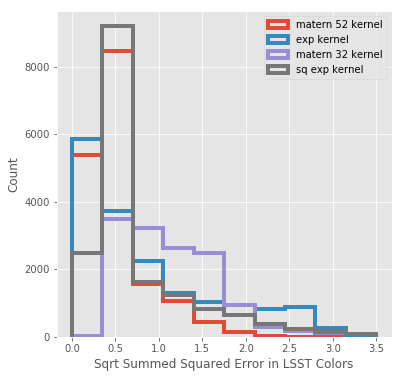

In [157]:
fig = plt.figure(figsize=(6,6))
n, bins, _ = plt.hist(m52_gp_tophat, histtype='step', label='matern 52 kernel', lw=4, range=(0, 3.5))
plt.hist(exp_gp_tophat, bins=bins, histtype='step', label='exp kernel', lw=4)
plt.hist(m32_gp_tophat, bins=bins, histtype='step', label='matern 32 kernel', lw=4, range=(0, 3.5))
plt.hist(sq_exp_gp_tophat, bins=bins, histtype='step', label='sq exp kernel', lw=4, range=(0, 3.5))
plt.legend()
plt.xlabel('Sqrt Summed Squared Error in LSST Colors')
plt.ylabel('Count')

In [203]:
np.exp(gp_spec.params)

array([[  5.21539321e-05,   2.06501955e+04],
       [  6.88418428e-06,   1.14698712e+03],
       [  5.55088960e-07,   1.26980338e+01],
       [  9.63955572e-07,   4.44568631e+02],
       [  3.21399287e-07,   3.53009374e+02],
       [  1.46336514e-07,   4.86578444e+01],
       [  1.45843357e-07,   3.88346871e+01],
       [  1.42177380e-07,   2.14567748e+02],
       [  1.83115332e-07,   5.08499259e+02],
       [  4.48984263e-08,   2.43188172e+01]])

### Create new templates at specific locations in color space

We once again select 5000 points where `ESP` was able to recreate the colors of the catalog the best.

In [204]:
min_err_idx = np.argsort(exp_gp_tophat)
min_err_idx = min_err_idx[:5000]

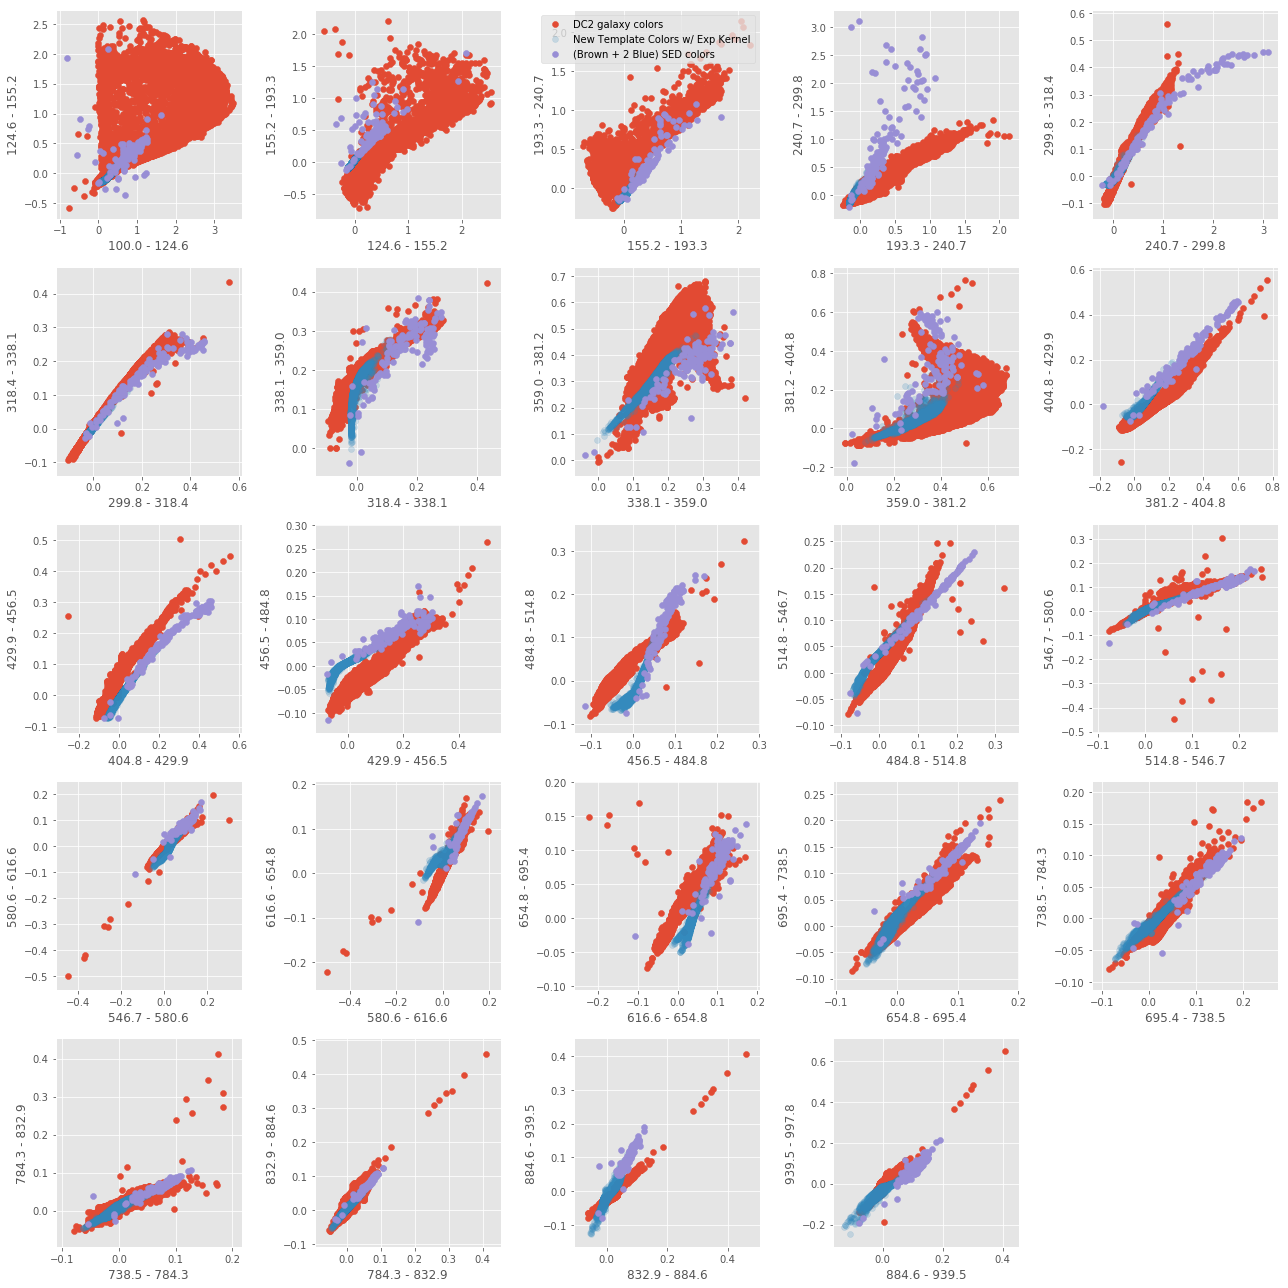

In [205]:
fig = plt.figure(figsize=(18,18))
color_labels = ['%s - %s' % (sed_min_wave[i], sed_min_wave[i+1]) for i in range(25)]
for i in range(24):
    col_0 = i
    col_1 = i+1
    fig.add_subplot(5,5,i+1)
    plt.scatter(tophat_dc2_colors[:,col_0], tophat_dc2_colors[:,col_1], label='DC2 galaxy colors')
    plt.scatter(tophat_gp_colors[min_err_idx,i], tophat_gp_colors[min_err_idx,i+1], alpha=0.2, label='New Template Colors w/ Exp Kernel')
    plt.scatter(tophat_template_colors[:,col_0], tophat_template_colors[:,col_1], label='(Brown + 2 Blue) SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

As before, we cluster these high-grade templates into 50 clusters in color space and randomly choose one template from each cluster and use the PCA coefficients for these points in color space to generate a new set of 50 templates to complement the (Brown + 2 Blue) templates.

In [206]:
rand_state = np.random.RandomState(3213)
kmeans = KMeans(n_clusters = 50, random_state=rand_state).fit(tophat_gp_colors[min_err_idx])

In [207]:
new_template_idx = []
for cluster_num in range(50):
    cluster_idx = np.where(kmeans.labels_ == cluster_num)[0]
    new_template_idx.append(rand_state.choice(min_err_idx[cluster_idx]))

In [208]:
new_templates = gp_spec.reconstruct_spectra(10)[new_template_idx]

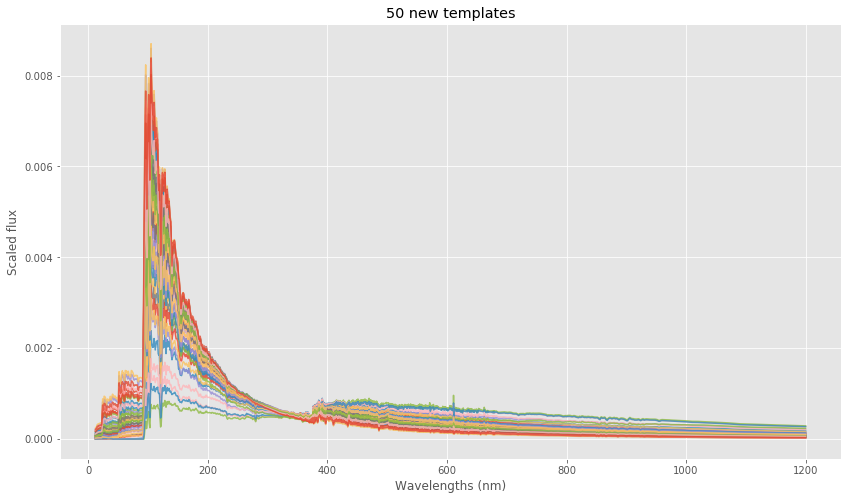

In [209]:
fig = plt.figure(figsize=(14, 8))
for i in range(50):
    plt.plot(new_pca_obj.wavelengths, new_templates[i], alpha=0.8)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Scaled flux')
plt.title('50 new templates')

Once again, we take the new templates and see where they are in color space compared to DC2 and the (Brown + 2 Blue) templates

In [210]:
lsst_tophat_template_colors = []
for sed_template in new_templates:
    test_sed = Sed()
    test_sed.setSED(wavelen=new_pca_obj.wavelengths, flambda=sed_template)
    maglist = lsst_bandpass_dict.magListForSed(test_sed)
    colors_list = maglist[:-1] - maglist[1:]
    lsst_tophat_template_colors.append(colors_list)

In [211]:
tophat_template_colors_lsst = np.array(lsst_tophat_template_colors)

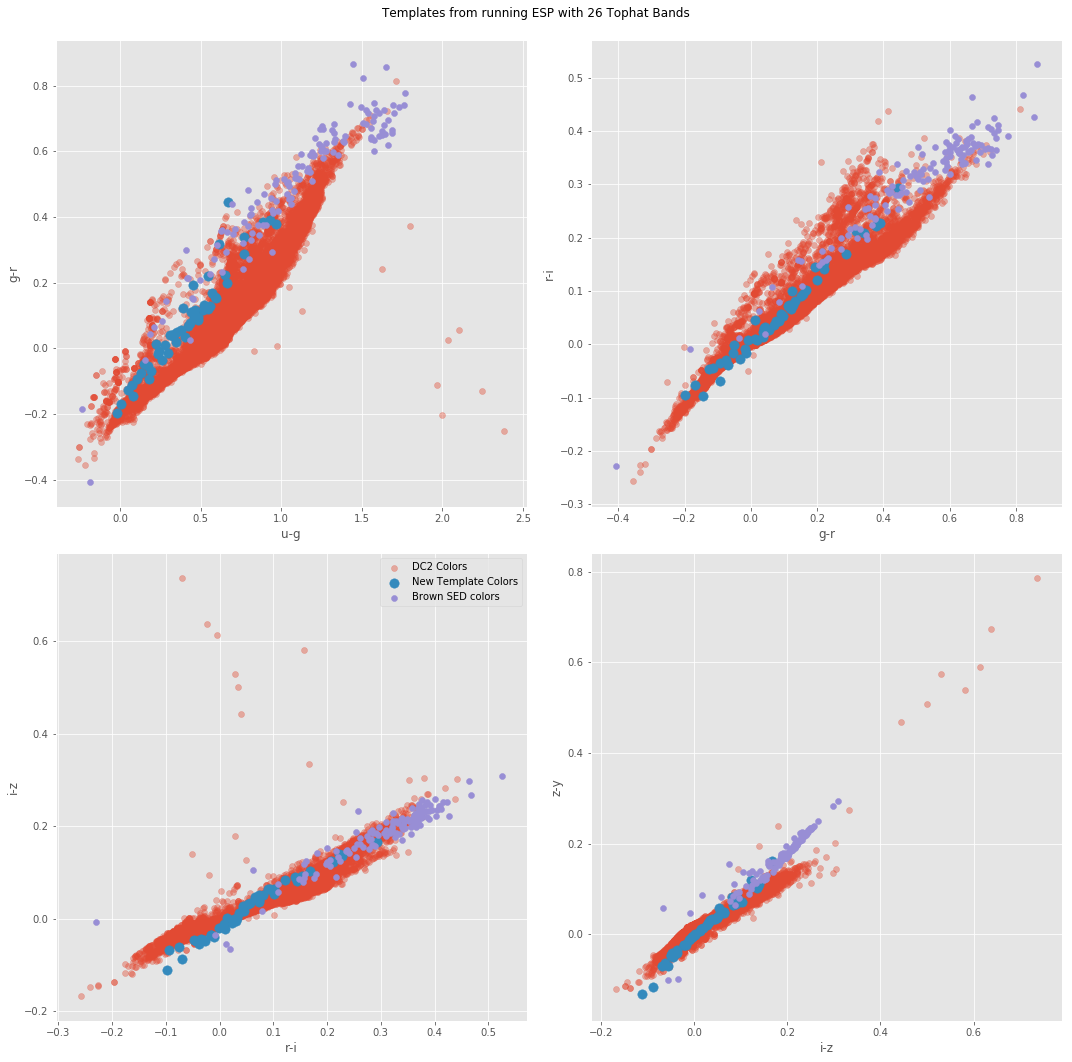

In [218]:
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']

fig = plt.figure(figsize=(15,15))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors', alpha=0.4)
    plt.scatter(tophat_template_colors_lsst[:,i], tophat_template_colors_lsst[:,i+1], label='New Template Colors', s=88)
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='Brown SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle('Templates from running ESP with 26 Tophat Bands')

In [168]:
### To write the new templates to file:
# (Changed to be written in angstroms to be consistent with Brown templates given)
template_folder = 'new_templates_tophat'
os.mkdir(template_folder)
sed_names = []
spec_on = 0
for sed_obj in new_templates:
    with open(os.path.join(template_folder, '%i.sed' % spec_on), 'w') as f:
        f.write('# Wavelength(angstrom)  Flambda(ergs/cm^s/s/angstrom)\n')
        for line_idx in range(len(new_pca_obj.wavelengths)):
            print(10.*new_pca_obj.wavelengths[line_idx], 0.1*sed_obj[line_idx], file=f)
    spec_on += 1